In [1]:
import os

from pdbfixer import PDBFixer
import openmm as mm
from openmm import unit
from openmm import app
import numpy as np
from matplotlib import pyplot as plt

# Preparing Barnase 

## Obtaining best chain

From barnase-barstar pdb previously analyzed, it was identifed that the "best" barnase chain contain 110 residues and 878 atoms, so the task is to identify it from the 12 chains in the pdb. 

In [2]:
fixer = PDBFixer(filename='1brs.pdb')

In [23]:
for chain in fixer.topology.chains():
    for residue in chain.residues():
        for atom in residue.atoms():
            print(chain.index, residue.index, residue.id, residue.name, atom.index, atom.id, atom.name)

0 0 3 VAL 0 1 N
0 0 3 VAL 1 2 CA
0 0 3 VAL 2 3 C
0 0 3 VAL 3 4 O
0 0 3 VAL 4 5 CB
0 0 3 VAL 5 6 CG1
0 0 3 VAL 6 7 CG2
0 1 4 ILE 7 8 N
0 1 4 ILE 8 9 CA
0 1 4 ILE 9 10 C
0 1 4 ILE 10 11 O
0 1 4 ILE 11 12 CB
0 1 4 ILE 12 13 CG1
0 1 4 ILE 13 14 CG2
0 1 4 ILE 14 15 CD1
0 2 5 ASN 15 16 N
0 2 5 ASN 16 17 CA
0 2 5 ASN 17 18 C
0 2 5 ASN 18 19 O
0 2 5 ASN 19 20 CB
0 2 5 ASN 20 21 CG
0 2 5 ASN 21 22 OD1
0 2 5 ASN 22 23 ND2
0 3 6 THR 23 24 N
0 3 6 THR 24 25 CA
0 3 6 THR 25 26 C
0 3 6 THR 26 27 O
0 3 6 THR 27 28 CB
0 3 6 THR 28 29 OG1
0 3 6 THR 29 30 CG2
0 4 7 PHE 30 31 N
0 4 7 PHE 31 32 CA
0 4 7 PHE 32 33 C
0 4 7 PHE 33 34 O
0 4 7 PHE 34 35 CB
0 4 7 PHE 35 36 CG
0 4 7 PHE 36 37 CD1
0 4 7 PHE 37 38 CD2
0 4 7 PHE 38 39 CE1
0 4 7 PHE 39 40 CE2
0 4 7 PHE 40 41 CZ
0 5 8 ASP 41 42 N
0 5 8 ASP 42 43 CA
0 5 8 ASP 43 44 C
0 5 8 ASP 44 45 O
0 5 8 ASP 45 46 CB
0 5 8 ASP 46 47 CG
0 5 8 ASP 47 48 OD1
0 5 8 ASP 48 49 OD2
0 6 9 GLY 49 50 N
0 6 9 GLY 50 51 CA
0 6 9 GLY 51 52 C
0 6 9 GLY 52 53 O
0 7 10 VAL 53 54 N

In [22]:
help(residue.atoms)

Help on method atoms in module openmm.app.topology:

atoms() method of openmm.app.topology.Residue instance
    Iterate over all Atoms in the Residue.



In [24]:
fixer.removeChains([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [25]:
fixer.topology

<Topology; 1 chains, 110 residues, 878 atoms, 899 bonds>

In [27]:
list_chains = list(fixer.topology.chains())

In [29]:
list_chains[0].id

'B'

Although manually, the barnase chain was identified.

<div class="alert alert-info">
<strong>Question:</strong> Is there a more efficient way to identify the chain were looking for?
</div>

I don't have an answer now, but there should be a better way. We must keep it in mind. In the future we will try to rewrite these workflows with MolSysMT. This could be a good point to improve the library.

<div class="alert alert-info">
<strong>Question:</strong> How can call a list in an object in order to print all the residues?
</div>

Do you mean something like the following?

In [30]:
for chain in fixer.topology.chains():
    for residue in chain.residues():
        print(chain.id, residue.name)

B ALA
B GLN
B VAL
B ILE
B ASN
B THR
B PHE
B ASP
B GLY
B VAL
B ALA
B ASP
B TYR
B LEU
B GLN
B THR
B TYR
B HIS
B LYS
B LEU
B PRO
B ASP
B ASN
B TYR
B ILE
B THR
B LYS
B SER
B GLU
B ALA
B GLN
B ALA
B LEU
B GLY
B TRP
B VAL
B ALA
B SER
B LYS
B GLY
B ASN
B LEU
B ALA
B ASP
B VAL
B ALA
B PRO
B GLY
B LYS
B SER
B ILE
B GLY
B GLY
B ASP
B ILE
B PHE
B SER
B ASN
B ARG
B GLU
B GLY
B LYS
B LEU
B PRO
B GLY
B LYS
B SER
B GLY
B ARG
B THR
B TRP
B ARG
B GLU
B ALA
B ASP
B ILE
B ASN
B TYR
B THR
B SER
B GLY
B PHE
B ARG
B ASN
B SER
B ASP
B ARG
B ILE
B LEU
B TYR
B SER
B SER
B ASP
B TRP
B LEU
B ILE
B TYR
B LYS
B THR
B THR
B ASP
B HIS
B TYR
B GLN
B THR
B PHE
B THR
B LYS
B ILE
B ARG


I don't know why they did like that. The object 'chains' or 'residues' are iterators and not lists:

In [31]:
type(fixer.topology.chains)

method

In [32]:
type(fixer.topology.chains())

list_iterator

A list can be created from an iterator, easy:

In [33]:
chains = list(fixer.topology.chains())

In [34]:
type(chains)

list

In [35]:
chains[0]

<Chain 0>

## Editing

Using PDBFixer, we can add residues, atoms and water molecules to our system.

In [87]:
fixer = PDBFixer(filename='1brs.pdb')
fixer.removeChains([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [37]:
fixer.findMissingResidues()
missing_residues = fixer.missingResidues
print(f"{len(missing_residues)} missing residues")

fixer.findNonstandardResidues()
nonstandard_residues = fixer.nonstandardResidues
print(f"{len(nonstandard_residues)} non standard residues")

fixer.findMissingAtoms()
missing_atoms = fixer.missingAtoms
missing_terminals = fixer.missingTerminals
print(f"{len(missing_atoms)} missing atoms")
print(f"{len(missing_terminals)} missing terminals")

0 missing residues
0 non standard residues
0 missing atoms
0 missing terminals


In [38]:
if len(nonstandard_residues)>0:
    fixer.replaceNonstandardResidues()

if len(missing_atoms)>0:
    fixer.addMissingAtoms()

Let's see how some aminoacids change when different pH is taken to protonate the system:

In [39]:
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')

In [43]:
counter = {'HIP':[], 'HIE':[], 'HID':[]}
pHs = np.linspace(1, 14, 20)

for pH in pHs:
    for residue in counter:
        counter[residue].append(0)
    modeller = app.Modeller(fixer.topology, fixer.positions)
    residues_protonated = modeller.addHydrogens(forcefield=forcefield, pH=pH)
    for residue in residues_protonated:
        if residue is not None:
            counter[residue][-1]+=1

In [46]:
counter.keys()

dict_keys(['HIP', 'HIE', 'HID'])

In [48]:
pHs

array([ 1.        ,  1.68421053,  2.36842105,  3.05263158,  3.73684211,
        4.42105263,  5.10526316,  5.78947368,  6.47368421,  7.15789474,
        7.84210526,  8.52631579,  9.21052632,  9.89473684, 10.57894737,
       11.26315789, 11.94736842, 12.63157895, 13.31578947, 14.        ])

In [50]:
counter['HID']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

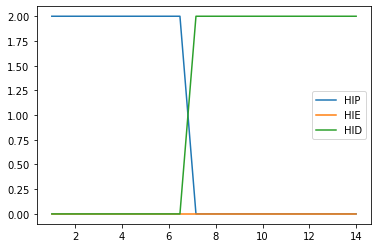

In [51]:
for residue in counter:
    plt.plot(pHs, counter[residue], label=residue)

plt.legend()
plt.show()

Is the protonated states something stationary along the simulation? The protonation state of certain residues depends on their chemical environment. We have here inferred how the histidine residues are protonated at different pHs. But: will this states change along the simulation? How can we define these states without ions and water molecules? Is the chemical environment of a given residue something that will change in time? If the protonated residues can change their state near pH 7, are we worried? Should we protonate after solvation?

We are interested in the interaction between barnase and barstar. Is any of the aminoacids with different possible protonated states in the interface or near?

What value of pH should you use? Are you interested in a simulation of the receptor in pure water? in the cytoplasm? in the nucleous? Is the pH different? Is it relevant?

In [61]:
atom.element.symbol

'O'

In [63]:
num_Hs = 0
for atom in fixer.topology.atoms():
    if (atom.element.symbol)=='H':
        num_Hs+=1

In [64]:
num_Hs

0

In [100]:
modeller = app.Modeller(fixer.topology, fixer.positions)

pH = 7.4
residues_protonated = modeller.addHydrogens(forcefield=forcefield, pH=pH)

In [101]:
num_Hs = 0
for atom in modeller.topology.atoms():
    if (atom.element.symbol)=='H':
        num_Hs+=1

In [102]:
num_Hs

849

In [103]:
[residue_name for residue_name in residues_protonated if residue_name is not None]

['HID', 'HID']

Let's see the charge of our system.

In [104]:
# Lets create a system with the protein in vacuum (infinite space) to get the charge

system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.NoCutoff)

total_charge = 0.0 * unit.elementary_charge
for force_index in range(system.getNumForces()):
    force = system.getForce(force_index)
    if isinstance(force, mm.NonbondedForce):
        for index in range(system.getNumParticles()):
            total_charge+=force.getParticleParameters(int(index))[0]

total_charge = np.round(total_charge._value)*total_charge.unit

In [105]:
total_charge

Quantity(value=2.0, unit=elementary charge)

What would be then charge of our protein at pH=6.5? What's the pH of the cell cytoplasm? Is the pH homogeneous in the cell? Are there regions with differen pH? What pH should we choose?

In [106]:
app.PDBFile.writeFile(modeller.topology, modeller.positions, open('barnase.pdb', 'w'))

## Finishing with Modeller

In order to build a system with an specific water model and box shape, Modeller is a great tool.

In [ ]:
pdb = app.PDBFile('barnase.pdb')

In [ ]:
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')

In [ ]:
modeller = app.Modeller(pdb.topology, pdb.positions)

In [ ]:
modeller.addSolvent(forcefield, model='tip3p')

Did we add ions? What's the charge of the solvated system?

In the README.md file there were some indications about how barnase had to be solvated. Did you follow them? Is the box a truncated octahedral box with the protein in the center and the limits of the box 14 angstroms away from the protein surface (at least)?

Could you show with NGLView the water box?